# M3CAD Generation Inference Demo

This notebook demonstrates the inference process for the M3CAD generation model. It covers:
1.  Loading a pre-trained model (VAE/WAE).
2.  Generating novel peptide sequences conditioned on desired properties.
3.  Analyzing the physicochemical properties of the generated sequences.

In [1]:
import os
import time
import torch
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from dataset import idx2ama, calculate_property
from model import SEQVAE, MMVAE, SEQWAE, MMWAE

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [2]:
# Configuration
class Args:
    gen_model = 'vae'  # 'vae' or 'wae'
    model = 'seq'      # 'seq', 'mm_unet', or 'mm_mt'
    classes = 4
    seq_length = 20
    use_augmentation = True
    mask_prob = 0.1
    condition = '1111' # Binary condition string
    gen_number = 100   # Number of sequences to generate
    # Path to your trained weights
    weight_path = 'runs/checkpoints/seq1/weights/best.pth' 

args = Args()

In [3]:
# Load Model
def load_model(args):
    if args.gen_model == 'vae':
        if args.model == 'seq':
            model = SEQVAE(args.classes, sequence_length=args.seq_length, use_augmentation=args.use_augmentation, mask_prob=args.mask_prob)
        elif args.model == 'mm_unet':
            model = MMVAE(args.classes, sequence_length=args.seq_length, use_encoder_feature=True, use_augmentation=args.use_augmentation, mask_prob=args.mask_prob)
        elif args.model == 'mm_mt':
            model = MMVAE(args.classes, sequence_length=args.seq_length, use_encoder_feature=False, use_augmentation=args.use_augmentation, mask_prob=args.mask_prob)
    elif args.gen_model == 'wae':
        if args.model == 'seq':
            model = SEQWAE(args.classes, sequence_length=args.seq_length, use_augmentation=args.use_augmentation, mask_prob=args.mask_prob)
        elif args.model == 'mm_unet':
            model = MMWAE(args.classes, sequence_length=args.seq_length, use_encoder_feature=True, use_augmentation=args.use_augmentation, mask_prob=args.mask_prob)
        elif args.model == 'mm_mt':
            model = MMWAE(args.classes, sequence_length=args.seq_length, use_encoder_feature=False, use_augmentation=args.use_augmentation, mask_prob=args.mask_prob)
    
    if os.path.exists(args.weight_path):
        model.load_state_dict(torch.load(args.weight_path, map_location=device))
        print(f"Loaded weights from {args.weight_path}")
    else:
        print(f"Warning: Weight file not found at {args.weight_path}. Using random weights.")

    model.to(device)
    model.eval()
    return model

model = load_model(args)

Loaded weights from runs/checkpoints/seq1/weights/best.pth


In [4]:
# Generation Loop
condition_list = [float(bit) for bit in args.condition]
condition = torch.tensor(condition_list).float().unsqueeze(0).to(device)

generated_sequences = []
properties_list = []
count = 0
seq_cache = set()

print(f"Generating {args.gen_number} sequences...")
start_time = time.time()

while count < args.gen_number:
    with torch.no_grad():
        z = torch.randn([condition.size(0), 32]).to(device)
        recon_seq_indices, random_gen, ori_seq = model.inference(z, condition)
        classify_result = model.cls_head(ori_seq.float())[0]
        
        # Basic filtering (optional)
        if classify_result.any() < 0.75:
           # continue
           pass # Skip filtering for demo purposes if model is not fully trained

        for batch_idx in range(recon_seq_indices.size(0)):
            pred = recon_seq_indices[batch_idx]
            if 21 in pred:
                zero_indices = torch.where(pred == 21)[0][0].item()
            elif 0 in pred:
                zero_indices = torch.where(pred == 0)[0][0].item()
            else:
                zero_indices = -1
            
            valid_indices = pred[:zero_indices] if zero_indices != -1 else pred
            pred_seq = [idx2ama[idx.item()] for idx in valid_indices]
            seq_str = ''.join(pred_seq)

            if 6 <= len(seq_str) <= 20 and seq_str not in seq_cache:
                seq_cache.add(seq_str)
                props = calculate_property(seq_str)
                generated_sequences.append(seq_str)
                properties_list.append(props)
                count += 1
                if count >= args.gen_number:
                    break

print(f"Generation complete in {time.time() - start_time:.2f}s")

Generating 100 sequences...


Generation complete in 1.57s


In [5]:
# Create DataFrame
property_names = [
    'Gravy Score', 'Aliphatic Index', 'Aromaticity', 'Instability Index',
    'Alpha Helix Fraction', 'Beta Helix Fraction', 'Turn Fraction',
    'Charge at pH 7', 'Isoelectric Point', 'Charge Density',
    'Average Hydrophobicity', 'Hydrophobic Moment'
]

df = pd.DataFrame(properties_list, columns=property_names)
df.insert(0, 'Sequence', generated_sequences)
df.head()

# Save intermediate results
df.to_csv('generation_results.csv', index=False)
print('Generation results saved to generation_results.csv')

Generation results saved to generation_results.csv


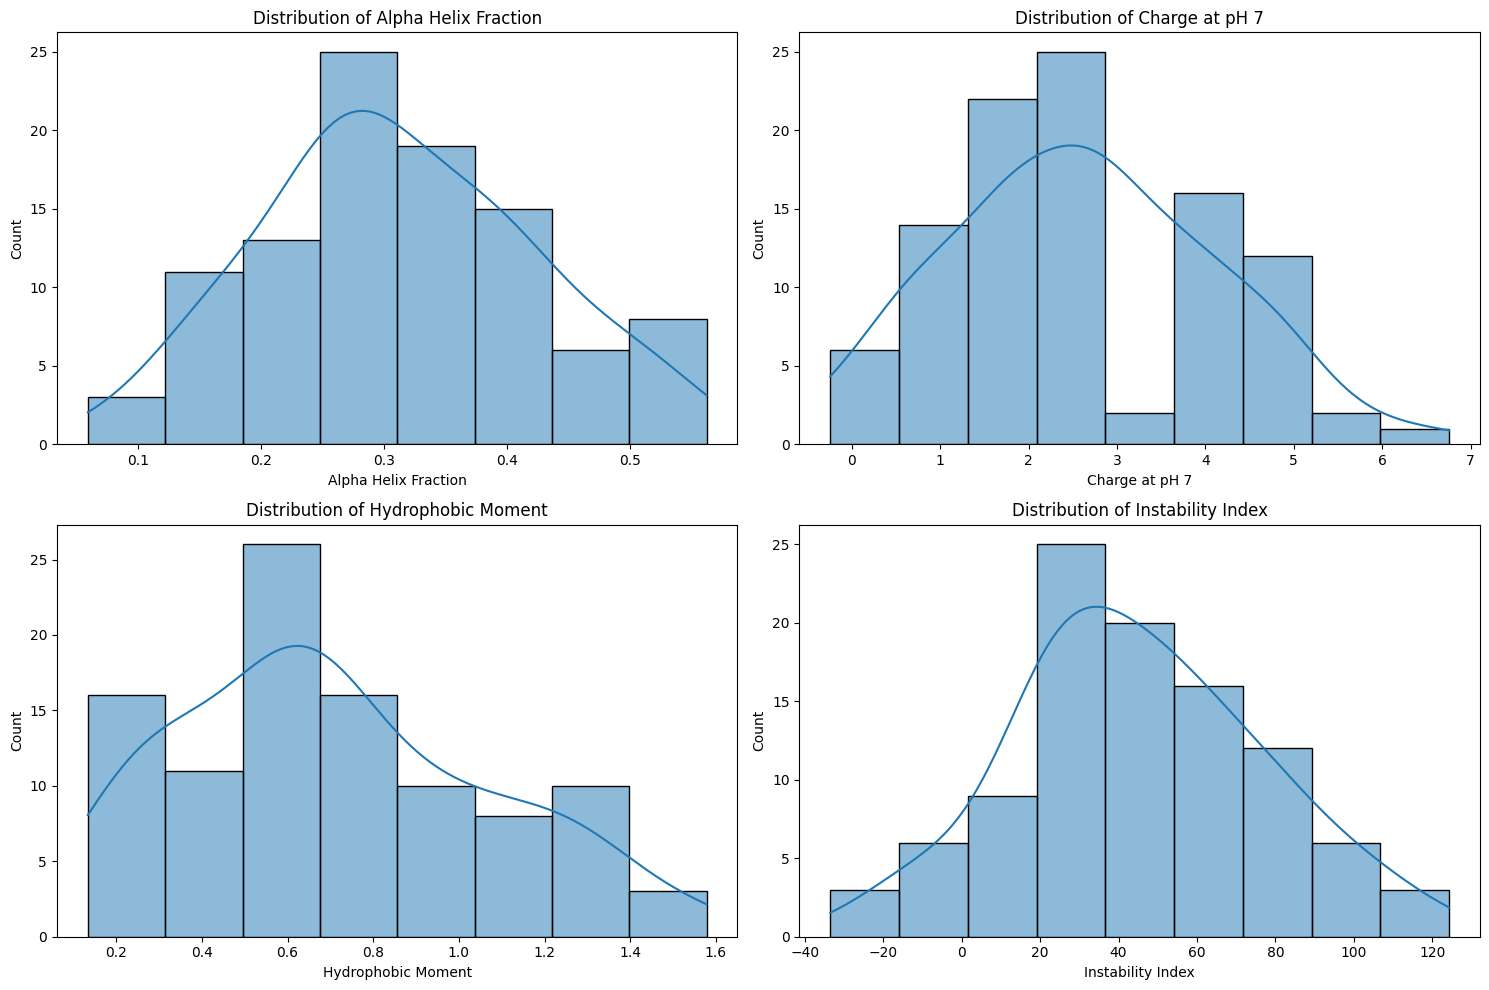

In [6]:
# Visualization
plt.figure(figsize=(15, 10))

metrics = ['Alpha Helix Fraction', 'Charge at pH 7', 'Hydrophobic Moment', 'Instability Index']

for i, metric in enumerate(metrics):
    plt.subplot(2, 2, i+1)
    sns.histplot(df[metric], kde=True)
    plt.title(f'Distribution of {metric}')

plt.tight_layout()
plt.show()